# Phân tích phân bố dữ liệu và xử lý ngoại lệ


Trong notebook này, chúng ta sẽ thực hiện các bước sau:

- Tổng quan dữ liệu
- Phân tích tỷ lệ giá trị thiếu
- Phân tích phân bố các biến số liên tục
- Phát hiện và loại bỏ ngoại lệ (outliers) bằng phương pháp IQR


In [606]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

Đọc dữ liệu từ file csv


In [607]:
# Load dữ liệu đã xử lý
df = pd.read_csv('../data/interim/preprocess.csv')

## 1. Tổng quan dữ liệu


- Kiểm tra kích thước dataset
- Thông tin chi tiết các cột (data types, missing)
- Thống kê mô tả các biến số


In [608]:
# Tự động chuyển các kiểu dữ liệu phù hợp
df = df.convert_dtypes()

print("Shape dữ liệu:", df.shape)
print(df.dtypes)
print(df.describe())


Shape dữ liệu: (25714, 11)
Price                 Float64
Area                  Float64
Bedrooms                Int64
Bathrooms               Int64
Floors                  Int64
AccessWidth           Float64
FacadeWidth           Float64
LegalStatus    string[python]
Furnishing     string[python]
District       string[python]
Province       string[python]
dtype: object
           Price       Area  Bedrooms  Bathrooms    Floors  AccessWidth  \
count    25714.0    25714.0   25547.0    25016.0   24851.0      22304.0   
mean   10.882215  73.288744  4.881669   4.771786  3.915416     6.223353   
std    11.369524  61.639646  5.107171   5.109953  1.724042     7.110253   
min          0.0        1.0       1.0        1.0       1.0          0.8   
25%         5.25     42.425       3.0        3.0       3.0          3.4   
50%          7.9       60.0       4.0        4.0       4.0          5.0   
75%      13.4975       82.0       5.0        5.0       5.0          7.0   
max        350.0      995.1  

**Nhận xét tổng quan:**

- Dữ liệu sau tiền xử lý gồm **25,714 dòng** và **11 thuộc tính**.
- Các kiểu dữ liệu đã được chuẩn hóa (`Float64`, `Int64`, `string[python]`).
- Một số trường số có dấu hiệu **phân phối lệch** hoặc có thể chứa **ngoại lệ**.
- Các trường phân loại đã được xử lý thống nhất, sẵn sàng cho phân tích tiếp theo.


## 2. Phân bố giá trị thiếu

- Thống kê số lượng và tỷ lệ missing values theo từng cột
- Vẽ biểu đồ tỷ lệ missing để trực quan hóa


             count  ratio (%)
Price            0   0.000000
Area             0   0.000000
Bedrooms       167   0.649452
Bathrooms      698   2.714475
Floors         863   3.356148
AccessWidth   3410  13.261258
FacadeWidth   2452   9.535662
LegalStatus      0   0.000000
Furnishing       0   0.000000
District         0   0.000000
Province         0   0.000000


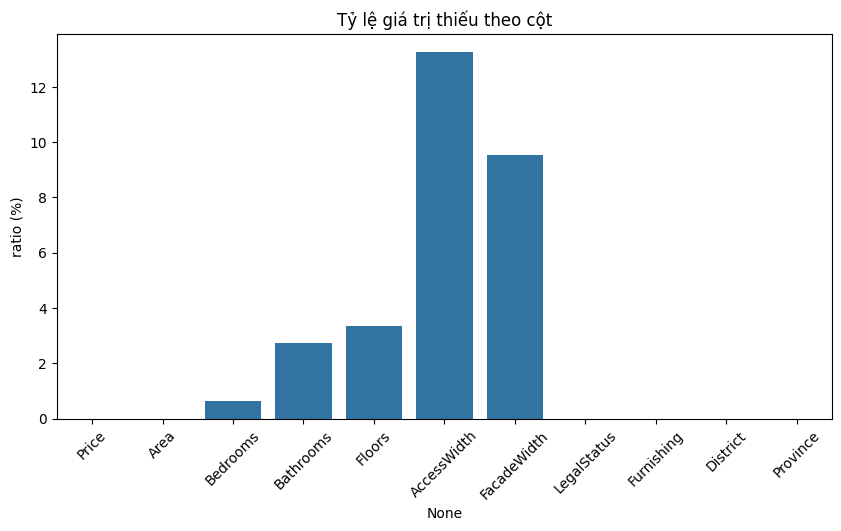

In [609]:
missing_counts = df.isna().sum()
missing_ratio = df.isna().mean() * 100
missing_df = pd.DataFrame({'count': missing_counts, 'ratio (%)': missing_ratio})
print(missing_df)

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_df.index, y=missing_df['ratio (%)'])
plt.title('Tỷ lệ giá trị thiếu theo cột')
plt.xticks(rotation=45)
plt.show()


**Phân tích giá trị thiếu:**

- Không thiếu: `Price`, `Area`, `LegalStatus`, `Furnishing`, `District`, `Province`.
- Thiếu ít: `Bedrooms` (~0.65%), `Bathrooms` (~2.7%), `Floors` (~3.36%) → có thể điền hoặc loại bỏ bản ghi.
- Thiếu nhiều: `AccessWidth` (~13.26%), `FacadeWidth` (~9.54%) → cần cân nhắc kỹ khi xử lý hoặc loại bỏ.


## 3. Phân tích phân bố các biến số liên tục


- Vẽ histogram để quan sát phân phối
- Vẽ boxplot để phát hiện các ngoại lệ (outliers)

Từ hai biểu đồ này, ta sẽ xác định ngưỡng percentile phù hợp (ví dụ 1% và 99%) để loại bỏ hoặc xử lý các giá trị bất thường


### a) Xây dựng hàm `analyze_and_filter_outliers`


Hàm này thực hiện phân tích phân phối dữ liệu của một cột số trong DataFrame, đồng thời lọc các giá trị ngoại lệ dựa trên ngưỡng percentile do người dùng xác định.

#### Tham số đầu vào:

- `df` (pandas.DataFrame): DataFrame chứa dữ liệu cần phân tích.
- `col` (str): Tên cột trong DataFrame muốn phân tích và lọc.
- `low_percentile` (float, mặc định=0.01): Ngưỡng phần trăm dưới để xác định giới hạn dưới của giá trị hợp lệ.
- `high_percentile` (float, mặc định=0.99): Ngưỡng phần trăm trên để xác định giới hạn trên của giá trị hợp lệ.

#### Các bước thực hiện:

1. Vẽ biểu đồ phân phối (histogram) và boxplot của dữ liệu gốc trong cột `col`.
2. Tính toán hai ngưỡng lọc dữ liệu dựa trên percentile `low_percentile` và `high_percentile`.
3. Lọc giữ lại các bản ghi có giá trị trong khoảng hai ngưỡng này.
4. Vẽ lại biểu đồ phân phối và boxplot của dữ liệu đã lọc.
5. In ra số lượng bản ghi còn lại sau khi lọc so với tổng số bản ghi ban đầu.
6. Trả về DataFrame sau khi lọc.

#### Trả về:

- `df_filtered` (pandas.DataFrame): DataFrame đã được lọc loại bỏ các ngoại lệ theo ngưỡng percentile.

---

Hàm này giúp dễ dàng phát hiện và loại bỏ các giá trị ngoại lệ (outliers) trong dữ liệu số nhằm tăng độ chính xác và ổn định cho các bước phân tích hoặc mô hình hóa sau này.


In [610]:
def analyze_and_filter_outliers(df, col, low_percentile=0.01, high_percentile=0.99):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Vẽ histogram và boxplot ban đầu
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col].dropna(), bins=50, kde=True)
    plt.title(f'Phân bố ban đầu của {col}')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot ban đầu của {col}')
    plt.show()
    
    # Tính ngưỡng theo percentile
    low_bound = df[col].quantile(low_percentile)
    high_bound = df[col].quantile(high_percentile)
    print(f"Ngưỡng dưới: {low_bound}, Ngưỡng trên: {high_bound}")
    
    # Lọc dữ liệu theo ngưỡng
    df_filtered = df[(df[col] >= low_bound) & (df[col] <= high_bound)]
    
    # Vẽ lại histogram và boxplot sau lọc
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df_filtered[col].dropna(), bins=50, kde=True)
    plt.title(f'Phân bố sau lọc của {col}')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=df_filtered[col])
    plt.title(f'Boxplot sau lọc của {col}')
    plt.show()
    
    print(f"Số bản ghi sau lọc: {len(df_filtered)} / {len(df)}")
    
    return df_filtered


### b) Phân tích Area


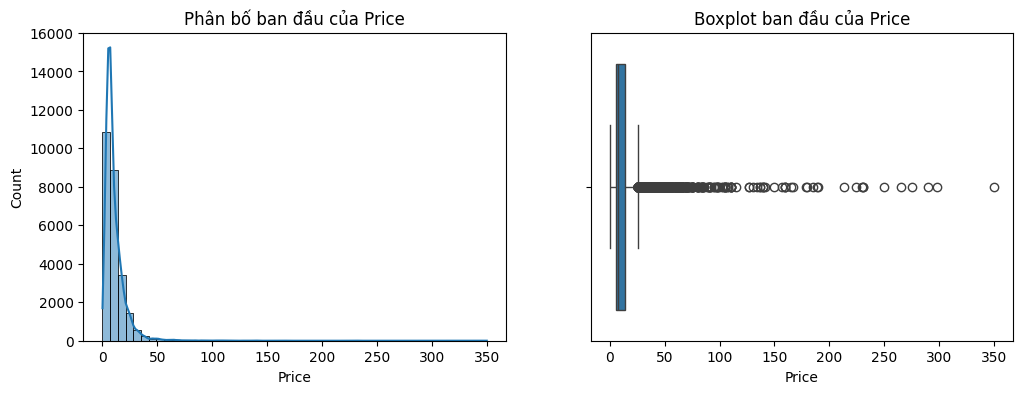

Ngưỡng dưới: 2.5, Ngưỡng trên: 26.8


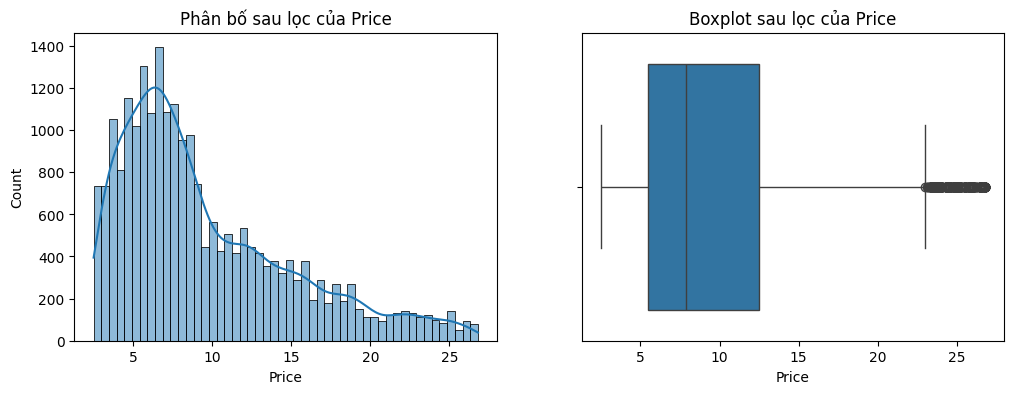

Số bản ghi sau lọc: 23189 / 25714


In [ ]:
df = analyze_and_filter_outliers(df, 'Price', low_percentile=0.05, high_percentile=0.95)

### c) Phân tích Bathrooms


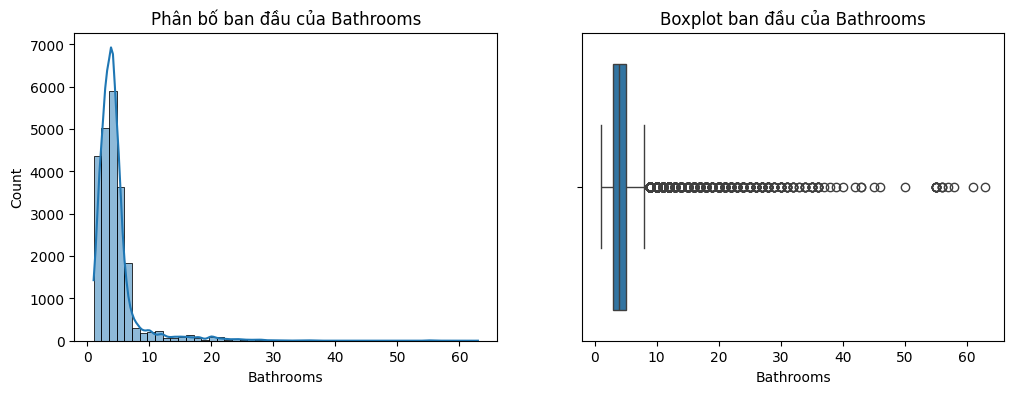

Ngưỡng dưới: 2, Ngưỡng trên: 10


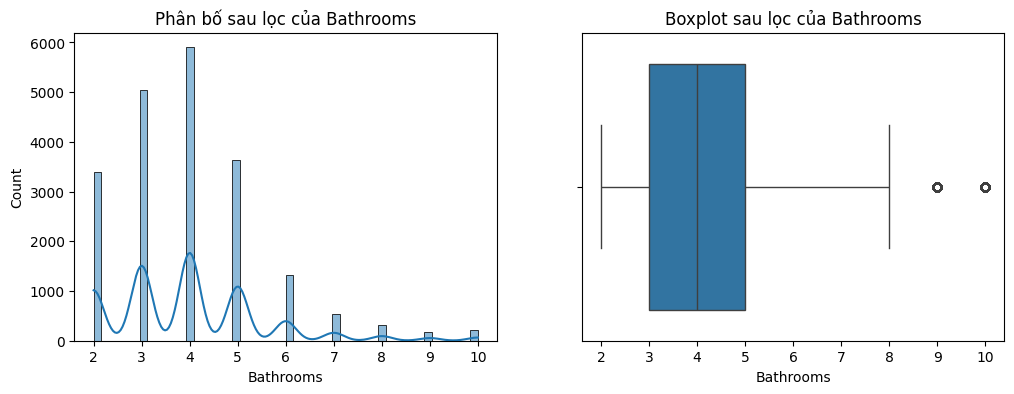

Số bản ghi sau lọc: 20512 / 23189


In [612]:
df = analyze_and_filter_outliers(df, 'Bathrooms', low_percentile=0.05, high_percentile=0.95)

### d) Phân tích Floors


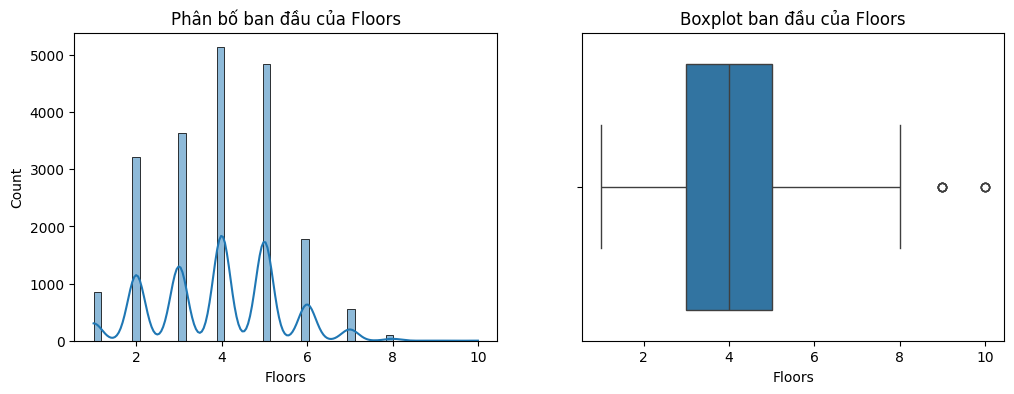

Ngưỡng dưới: 2, Ngưỡng trên: 6


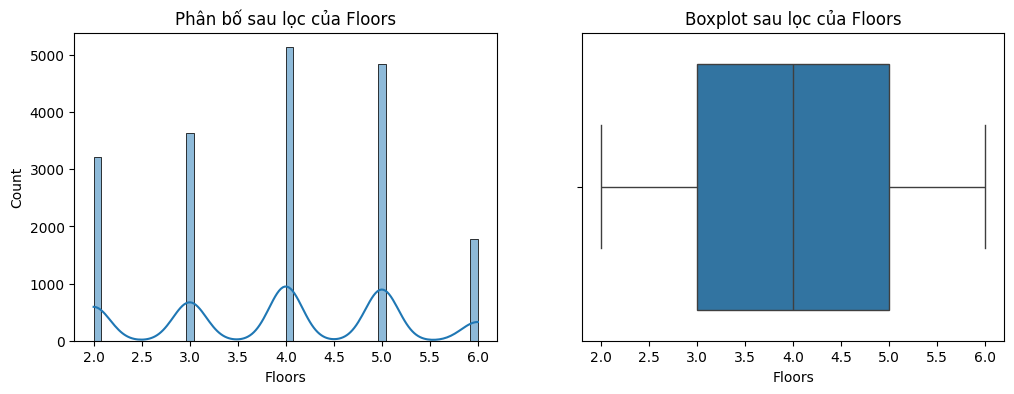

Số bản ghi sau lọc: 18584 / 20512


In [613]:
df = analyze_and_filter_outliers(df, 'Floors', low_percentile=0.05, high_percentile=0.95)

### e) Phân tích AccessWidth


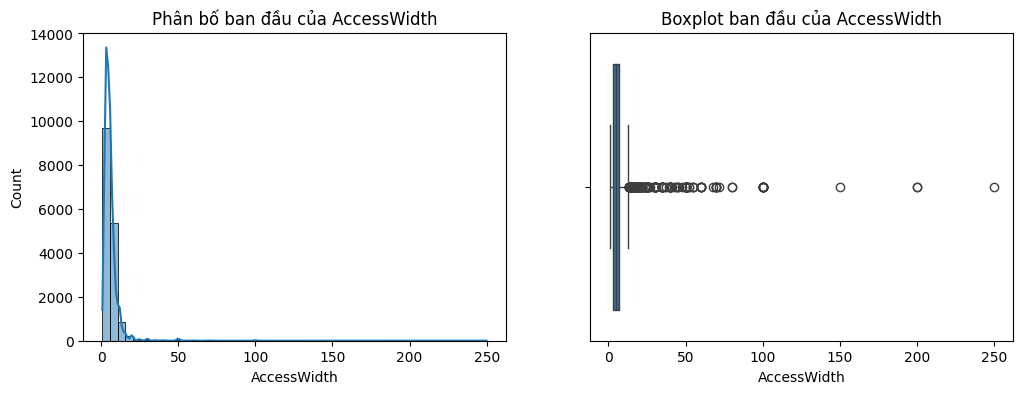

Ngưỡng dưới: 2.2, Ngưỡng trên: 12.0


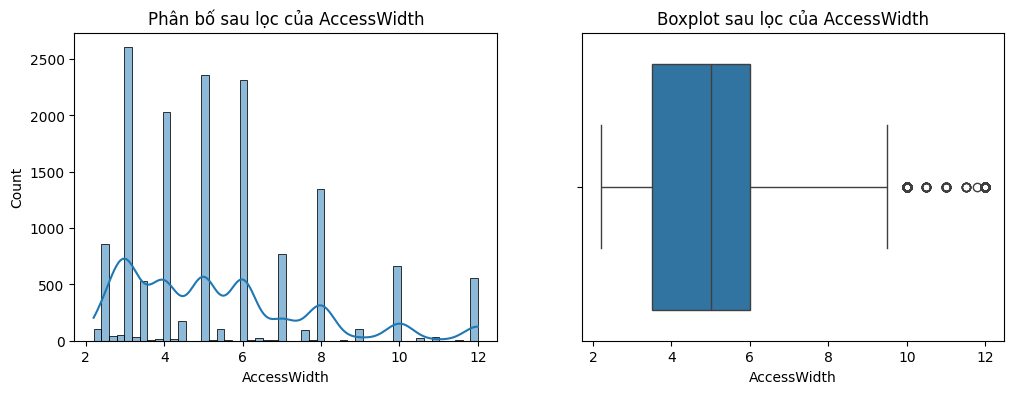

Số bản ghi sau lọc: 14888 / 18584


In [614]:
df = analyze_and_filter_outliers(df, 'AccessWidth', low_percentile=0.05, high_percentile=0.95)

### f) Phân tích FacadeWidth


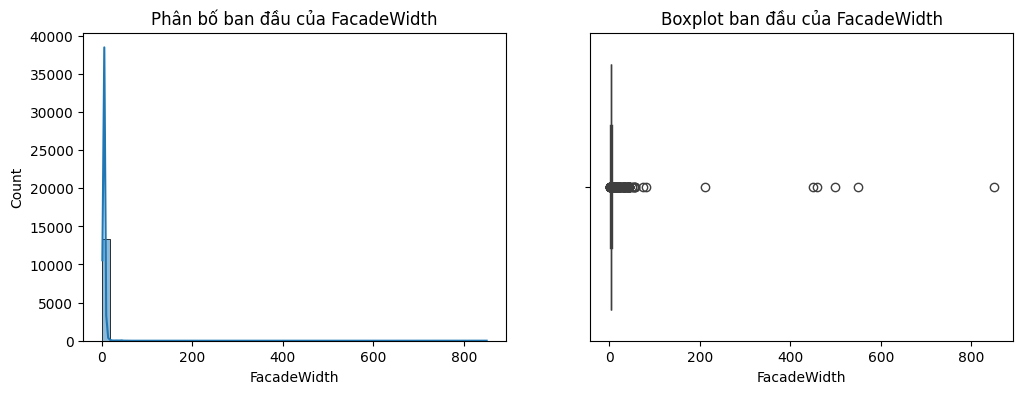

Ngưỡng dưới: 3.3625, Ngưỡng trên: 8.0


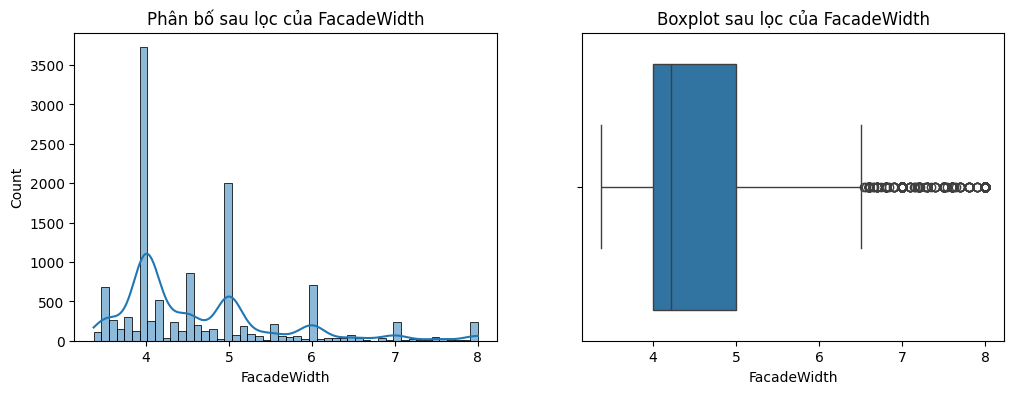

Số bản ghi sau lọc: 12253 / 14888


In [615]:
df = analyze_and_filter_outliers(df, 'FacadeWidth', low_percentile=0.05, high_percentile=0.95)

## 4. Phát hiện ngoại lệ (outliers) bằng phương pháp IQR

- Tính toán IQR (Interquartile Range)
- Xác định các điểm dữ liệu nằm ngoài khoảng [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
- Đếm số lượng ngoại lệ cho từng biến


In [616]:
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f'Biến {col}: có {outliers.shape[0]} ngoại lệ')
    return outliers.index

outlier_indices = set()
for col in numeric_cols:
    outliers = detect_outliers_iqr(df, col)
    outlier_indices.update(outliers)

print(f'Tổng số bản ghi ngoại lệ (có thể trùng lặp): {len(outlier_indices)}')


Biến Bedrooms: có 181 ngoại lệ
Tổng số bản ghi ngoại lệ (có thể trùng lặp): 181


## 5. Loại bỏ ngoại lệ

- Loại bỏ các bản ghi chứa ngoại lệ ở bất kỳ biến nào
- Kiểm tra lại kích thước dữ liệu sau khi loại bỏ


In [617]:
df_clean = df.drop(index=outlier_indices)
print("Sau khi loại bỏ ngoại lệ, shape dữ liệu:", df_clean.shape)

# Lưu dữ liệu sạch để sử dụng cho bước tiếp theo
df_clean.to_csv('../data/processed/data_clean.csv', index=False)


Sau khi loại bỏ ngoại lệ, shape dữ liệu: (12072, 11)
